<a href="https://colab.research.google.com/github/darthwaydr007/gan/blob/master/AC_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

There are 1 GPU available.
GPU: Tesla T4


In [2]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
BATCH_SIZE = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
EPOCHS = 20
LR = 2e-3
CLASSES = 10

In [6]:

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

mnist_train = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='/content/drive/My Drive/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True)

Extracting /content/drive/My Drive/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/MNIST/MNIST/raw


Extracting /content/drive/My Drive/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/MNIST/MNIST/raw


Extracting /content/drive/My Drive/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/MNIST/MNIST/raw


Extracting /content/drive/My Drive/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 4 x 4
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.Softmax()
        )
        self.disc = nn.Sequential(
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        disc = self.disc(out)
        classes = self.classes(flatten)
        return {
            'disc_output' : disc.cuda(),
            'disc_classes' : classes.cuda(),
            'features' : flatten.cuda()
        }

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #self.emb = nn.Embedding(CLASSES, nz)
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 2, 2, 2, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.model(input).cuda()

In [9]:
mnist_dim = 784

In [10]:
G = Generator().to(device)
D = Discriminator().to(device)
criterion_disc = nn.BCELoss()
criterion_aux = nn.NLLLoss()
G_optimizer = optim.Adam(G.parameters(), lr = LR)
D_optimizer = optim.Adam(D.parameters(), lr = LR) 

In [11]:
def D_train(x , label , train):
  x_real, y_real = x.view(BATCH_SIZE, nc, 28, 28).cuda(), torch.ones(BATCH_SIZE, 1).cuda()
  #z = torch.randn(BATCH_SIZE, nz, 1, 1).to(device)
  #fake_label = np.random.randint(0, 10, BATCH_SIZE)
  fake_label = torch.randint(10 , (BATCH_SIZE,)).cuda()
  onehot = torch.zeros(BATCH_SIZE, CLASSES)
  onehot[np.arange(BATCH_SIZE), fake_label] = 1
  noise = torch.randn(BATCH_SIZE, nz)
  noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
  z = noise.view(BATCH_SIZE, nz, 1, 1).to(device)

    
  if train == True:
    G.train()
    D.train()
    D.zero_grad()

    # train discriminator on real
    x_fake, y_fake = G(z), torch.zeros(BATCH_SIZE, 1).to(device)

    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    D_real_disc_loss = criterion_disc(D_output1_disc, y_real)
    D_real_aux_loss = criterion_aux(D_output1_aux , label)
    D_real_loss = D_real_disc_loss+D_real_aux_loss
    D_real_loss.backward()

    # train discriminator on facke
    data = D(x_fake)
    D_output2_disc = data['disc_output']
    D_output2_aux = data['disc_classes']
    D_fake_disc_loss = criterion_disc(D_output2_disc, y_fake)
    D_fake_aux_loss = criterion_aux(D_output2_aux, fake_label)
    D_fake_loss = D_fake_disc_loss+D_fake_aux_loss
    D_fake_loss.backward()

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    #D_loss.backward()
    D_optimizer.step()
    #print(D_output1_aux.shape)
    return {
        'loss' : D_loss.data.item() ,
        'output' : D_output1_aux
    }
  else:
    D.eval()
    data = D(x_real)
    D_output1_disc = data['disc_output']
    D_output1_aux = data['disc_classes']
    return {
        'loss' : D_output1_disc ,
        'output' : D_output1_aux
    }


In [12]:
def G_train(label):
    G.train()
    D.train()
    G.zero_grad()


    #z = torch.randn(BATCH_SIZE, nz, 1, 1).to(device)
    #fake_label = torch.randint(10 , (BATCH_SIZE,))
    onehot = torch.zeros(BATCH_SIZE, CLASSES)
    onehot[np.arange(BATCH_SIZE), label] = 1
    noise = torch.randn(BATCH_SIZE, nz)
    noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
    z = noise.view(BATCH_SIZE, nz, 1, 1).to(device)

    y0 = torch.ones(BATCH_SIZE, 1).cuda()

    G_output = G(z)
    data = D(G_output)
    D_output_disc = data['disc_output']
    D_output_aux = data['disc_classes']
    G_disc_loss = criterion_disc(D_output_disc, y0)
    G_aux_loss = criterion_aux(D_output_aux , label)
    G_loss = G_disc_loss+G_aux_loss

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item() , G_output

In [13]:
def display_grid(images):
    grid_img = torchvision.utils.make_grid(images , nrow=8)
    npimgs = grid_img.cpu().detach().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.show()

In [14]:
n_epoch = 10

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


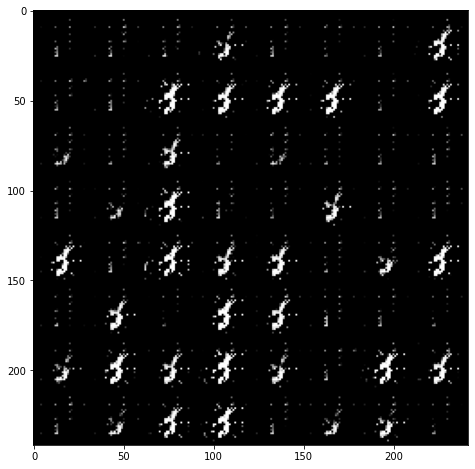

[1/10]: loss_d: -0.724, loss_g: 11.982
Accuracy Training :  0.683
Accuracy Testing :  0.6694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


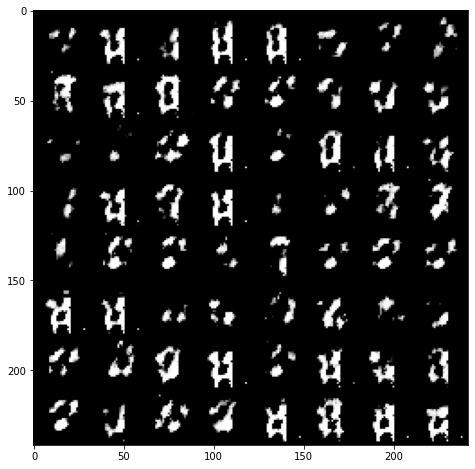

[2/10]: loss_d: -0.787, loss_g: 11.544
Accuracy Training :  0.771
Accuracy Testing :  0.7509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


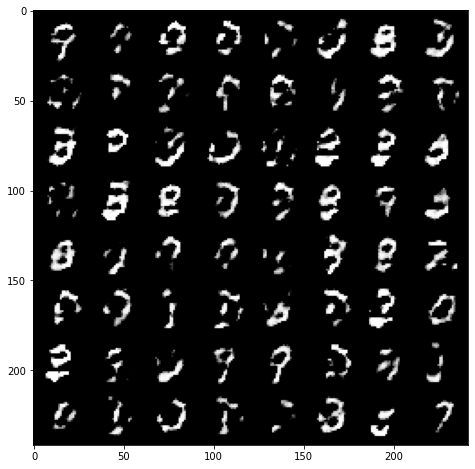

[3/10]: loss_d: -0.801, loss_g: 9.607
Accuracy Training :  0.819
Accuracy Testing :  0.9092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


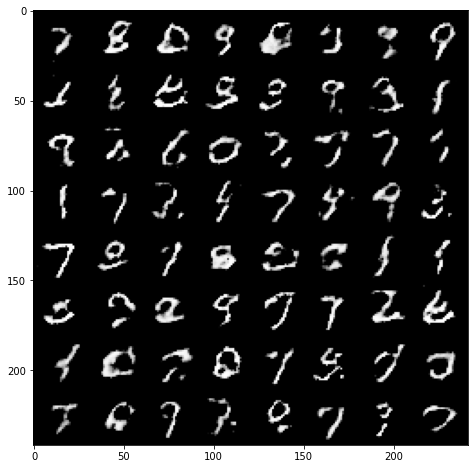

[4/10]: loss_d: -0.835, loss_g: 7.110
Accuracy Training :  0.918
Accuracy Testing :  0.9313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


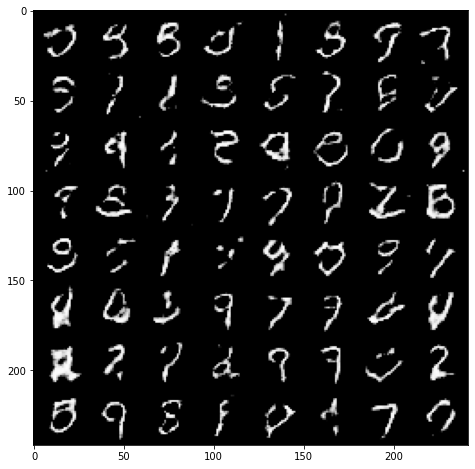

[5/10]: loss_d: -0.772, loss_g: 5.321
Accuracy Training :  0.933
Accuracy Testing :  0.9463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


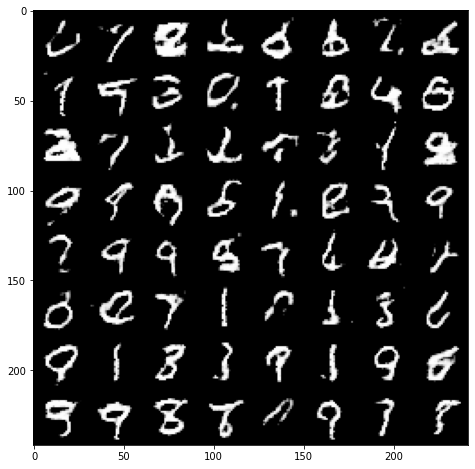

[6/10]: loss_d: -0.657, loss_g: 4.535
Accuracy Training :  0.942
Accuracy Testing :  0.9594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


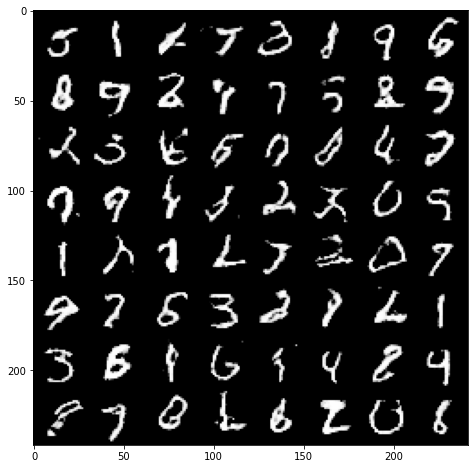

[7/10]: loss_d: -0.605, loss_g: 3.832
Accuracy Training :  0.952
Accuracy Testing :  0.9539


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


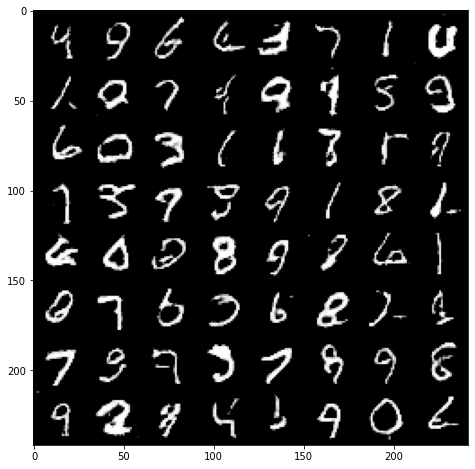

[8/10]: loss_d: -0.552, loss_g: 3.438
Accuracy Training :  0.955
Accuracy Testing :  0.9594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


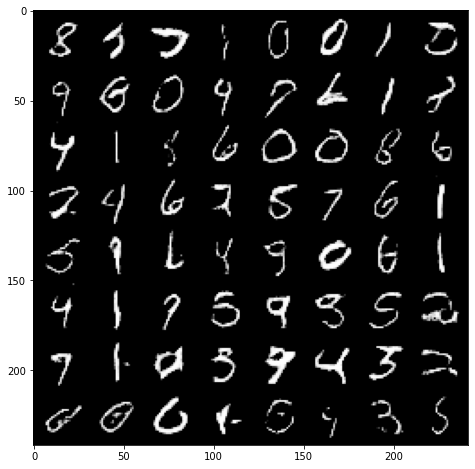

[9/10]: loss_d: -0.465, loss_g: 3.195
Accuracy Training :  0.96
Accuracy Testing :  0.9578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


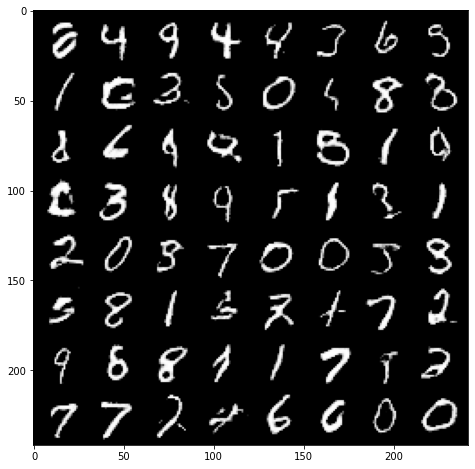

[10/10]: loss_d: -0.509, loss_g: 2.985
Accuracy Training :  0.964
Accuracy Testing :  0.9587


In [15]:


for epoch in range(1, n_epoch+1):
    correct = 0
    total = 0           
    D_losses, G_losses = [], []
        #=======================Train=======================#
    for batch_idx, (x, label) in enumerate(train_loader):

        d  = D_train(x , label.cuda() , train = True)
        d_loss = d['loss']
        output = d['output']
        g_loss , g_images= G_train(label.cuda())
        D_losses.append(d_loss)
        G_losses.append(g_loss)

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        if batch_idx % 750 == 0 and not batch_idx == 0:
          #print(label.size(0))
          g_images = g_images.resize(BATCH_SIZE,1,28,28)
          display_grid(g_images)
          #display_grid(x)
          #print('D(X) : {:}   || D(G(Z)) : {:}'.format(d_loss , g_loss))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    print('Accuracy Training : ' , round(correct/total , 3))
    correct = 0
    total = 0
    #=======================Test=======================#
    with torch.no_grad():
      for batch_idx, (x, label) in enumerate(test_loader):
          d  = D_train(x , label.cuda() , train = False)
          output = d['output']
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
      print('Accuracy Testing : ' , round(correct/total , 4))


In [16]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 4 x 4
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.Softmax()
        )
    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        classes = self.classes(flatten)
        return classes.cuda()

In [17]:
classifier = MNISTClassifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr = LR)

In [18]:
for epoch in range(0, n_epoch): 
    #=======================Train=======================#
    classifier.train()
    correct = 0
    total = 0
    print('======== Epoch {:} / {:} ========'.format(epoch, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, (x, label) in enumerate(train_loader):
        optimizer.zero_grad()
        x_real = x.view(BATCH_SIZE, nc, 28, 28).cuda()
        output = classifier(x_real)
        loss = criterion_aux(output , label.cuda())

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        if batch_idx % 300 == 0 and not batch_idx == 0: 
          print('|| loss : {:} '.format( loss.mean().item()))   
        loss.backward()
        optimizer.step()
        

    print('Accuracy Training : ' , round(correct/total , 3))     
    #=======================Test=======================#    
    correct = 0
    total = 0
    classifier.eval()
    with torch.no_grad():
      for batch_idx, (x, label) in enumerate(test_loader):
        x_real = x.view(BATCH_SIZE, nc, 28, 28).cuda()
        output = classifier(x_real)
        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
    print('Accuracy Testing : ' , round(correct/total , 3))

======== Epoch 0 / 10 ========


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


|| loss : -0.9358545541763306 
|| loss : -0.8782342076301575 
|| loss : -0.9300786256790161 
Accuracy Training :  0.932
Accuracy Testing :  0.963
======== Epoch 1 / 10 ========
|| loss : -0.9411410093307495 
|| loss : -0.9922307133674622 
|| loss : -0.9932136535644531 
Accuracy Training :  0.966
Accuracy Testing :  0.974
======== Epoch 2 / 10 ========
|| loss : -0.9709113240242004 
|| loss : -0.9774681925773621 
|| loss : -0.9535527229309082 
Accuracy Training :  0.971
Accuracy Testing :  0.972
======== Epoch 3 / 10 ========
|| loss : -0.9803606867790222 
|| loss : -0.9843740463256836 
|| loss : -0.9840874075889587 
Accuracy Training :  0.974
Accuracy Testing :  0.98
======== Epoch 4 / 10 ========
|| loss : -0.9999995827674866 
|| loss : -0.9726020693778992 
|| loss : -0.9746299386024475 
Accuracy Training :  0.974
Accuracy Testing :  0.978
======== Epoch 5 / 10 ========
|| loss : -0.9836792349815369 
|| loss : -0.9771531224250793 
|| loss : -0.984375 
Accuracy Training :  0.977
Accura